In [ ]:
!pip install obspy wget cartopy

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr


import obspy
from obspy.clients.fdsn import Client

import plotly.express as px

import wget

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.colors import LightSource

import os.path


In [ ]:
client = Client("IRIS")

In [ ]:
def catalog2pandas(cat):

    times  = [ev.origins[0].time.datetime for ev in cat]
    lats   = [ev.origins[0].latitude for ev in cat]
    lons   = [ev.origins[0].longitude for ev in cat]
    mags   = [ev.magnitudes[0].mag for ev in cat]
    depths = [ev.origins[0].depth for ev in cat]

    descriptions=[ev.event_descriptions[0]['text'] for ev in cat]

    origin_dict = {'time':times,
                   'latitude':lats,
                   'longitude':lons,
                   'depth':depths,
                   'magnitude':mags,
                   'description':descriptions}

    events = pd.DataFrame.from_dict(origin_dict)

    events=events.sort_values(by='time');

    return events

In [ ]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

In [ ]:
client = Client("IRIS")

In [ ]:
t1 = obspy.UTCDateTime(2010,7,1)
t2 = obspy.UTCDateTime(2023,7,1)

minmagnitude = 5

minlat = 43
maxlat = 48
minlon = -121
maxlon = -125

cat = client.get_events(starttime = t1,
                        endtime = t2,
                        minmagnitude=minmagnitude,
                        minlatitude=minlat,
                        minlongitude=minlon,
                        maxlatitude=maxlat,
                        maxlongitude=maxlon)

In [ ]:
def catalog2pandas(cat):

    times  = [ev.origins[0].time.datetime for ev in cat]
    lats   = [ev.origins[0].latitude for ev in cat]
    lons   = [ev.origins[0].longitude for ev in cat]
    mags   = [ev.magnitudes[0].mag for ev in cat]
    depths = [ev.origins[0].depth for ev in cat]

    descriptions=[ev.event_descriptions[0]['text'] for ev in cat]

    origin_dict = {'time':times,
                   'latitude':lats,
                   'longitude':lons,
                   'depth':depths,
                   'magnitude':mags,
                   'description':descriptions}

    events = pd.DataFrame.from_dict(origin_dict)

    events=events.sort_values(by='time');

    return events

In [ ]:
events=catalog2pandas(cat)
events

time  latitude  longitude     depth  magnitude  \
430 2010-07-28 16:12:06.100   43.7821  -125.8547   14900.0        5.2   
429 2010-08-04 23:48:02.590   46.0031   153.3012   32000.0        6.0   
428 2010-09-07 11:30:52.350   45.7424   151.4845   33100.0        5.0   
427 2010-09-08 17:39:44.170   44.5074   149.8824   35000.0        5.5   
426 2010-09-08 19:25:59.390   44.4667   149.8938   34700.0        5.2   
..                      ...       ...        ...       ...        ...   
4   2023-06-23 13:27:53.913   44.8921   -28.0466   10000.0        5.2   
3   2023-06-23 15:13:08.480   44.7804   -27.9755   10000.0        5.3   
2   2023-06-23 17:39:14.156   45.8235   143.1062  324034.0        5.6   
1   2023-06-23 19:08:49.737   44.9414   -28.0321   10000.0        5.4   
0   2023-06-23 21:48:25.388   44.9547   -28.0502   10000.0        5.6   

                     description  
430          OFF COAST OF OREGON  
429                KURIL ISLANDS  
428                KURIL ISLANDS  
427                KURIL ISLANDS  
426                KURIL ISLANDS  
..                           ...  
4    NORTHERN MID-ATLANTIC RIDGE  
3    NORTHERN MID-ATLANTIC RIDGE  
2         HOKKAIDO, JAPAN REGION  
1    NORTHERN MID-ATLANTIC RIDGE  
0    NORTHERN MID-ATLANTIC RIDGE  

[431 rows x 6 columns]

In [ ]:
events['year'] = pd.DatetimeIndex(events['time']).year
events['marker_size'] =np.fix(np.exp(events['magnitude']))
events['magnitude bin'] = 0.5*np.fix(2*events['magnitude'])

In [ ]:
url = 'https://www.gmrt.org/services/GridServer?north={maxlat}&west={minlon}&east={maxlon}&south={minlat}&layer=topo&format=netcdf&resolution=high'


url=url.format(maxlat=50,
               minlon=-130,
               maxlon=-118,
               minlat=35)

topo_data='GMRTv4_1_1_20230806topo.grd'

if os.path.isfile(topo_data)==False:
    print('Downloading GMRT topography')
    print(url)
    topo_data=wget.download(url)

print(topo_data)

https://www.gmrt.org/services/GridServer?north=50&west=-130&east=-118&south=35&layer=topo&format=netcdf&resolution=high
GMRTv4_2_20240110topo.grd


In [ ]:
topo=xr.open_dataset(topo_data)
dim=np.flip(topo.dimension).values
z=topo.z.values
z=z.reshape(dim)
z[np.isnan(z)]=0;

x=np.linspace(topo.x_range[0],topo.x_range[1],dim[1])
y=np.linspace(topo.y_range[1],topo.y_range[0],dim[0])

In [ ]:
def plot_elevation(x,y,z, shade=True):


    central_longitude=0

    if np.max(x)>180:
        central_longitude=180
    if np.min(x)<-180:
        central_longitude=-180

    x=x-central_longitude

    if np.max(abs(x)>180):
        print('Check longitude range!')
        return np.nan

    cmap = plt.get_cmap('terrain')
    vmin = np.min(z)
    vmax = np.max(z)

    if shade:
        ls = LightSource(azdeg=315, altdeg=45)
        z = ls.shade(z, cmap=cmap,blend_mode='overlay',vert_exag=0.1)


    aspect=1/np.cos(np.pi/180*np.mean(y));

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    gl=ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines=None
    gl.ylines=None

    cax=plt.imshow(z,
                   cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   extent=[min(x),max(x),min(y),max(y)],
                   aspect=aspect)
    plt.colorbar(cax, shrink =0.25)
    ax.add_feature(cfeature.COASTLINE)
    return ax

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip



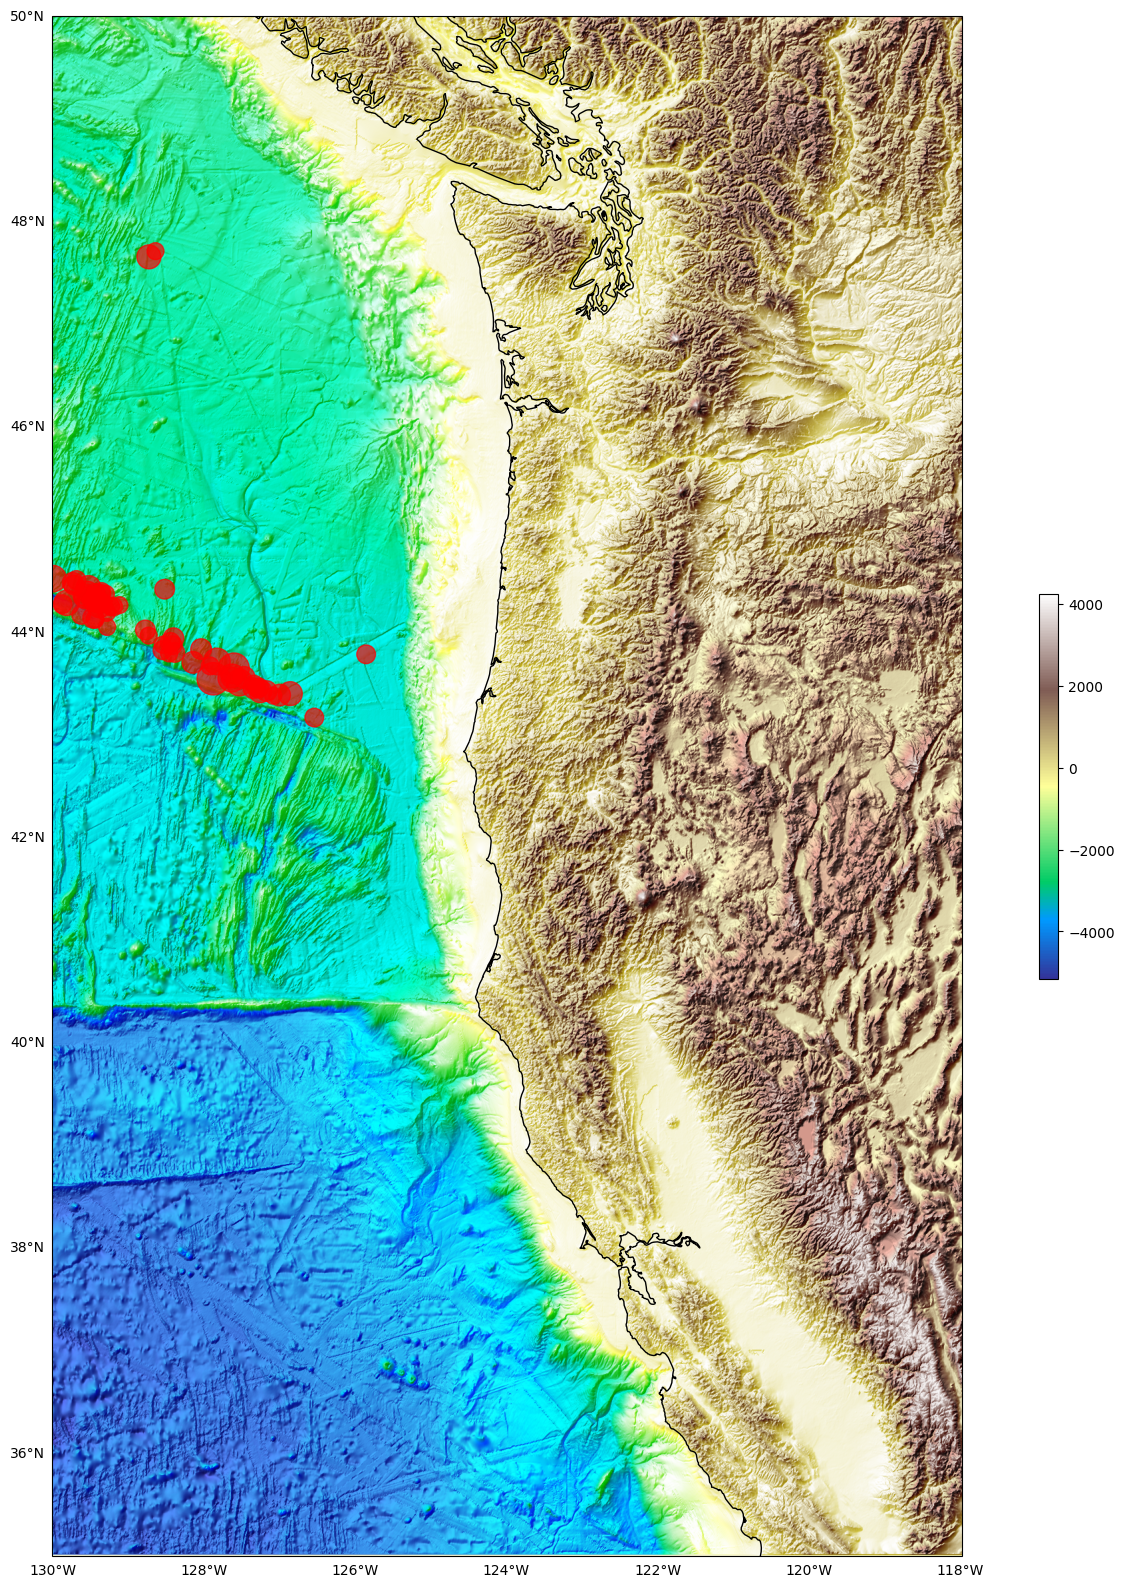

In [ ]:
plt.figure(figsize=(20,20))

ax=plot_elevation(x,y,z, shade=True)

ind= (events.longitude>min(x)) & (events.longitude<max(x)) & (events.latitude>min(y)) & (events.latitude<max(y));

plt.scatter(events[ind].longitude,
            events[ind].latitude,
            events[ind].marker_size,
            color='r',alpha=0.7,
            transform=ccrs.PlateCarree())

In [ ]:
slab_data = '/content/drive/MyDrive/MGG project group/datasets/cas_slab2_dep_02.24.18.grd'

In [ ]:


def plot_elevation(x,y,z, shade=True):

    central_longitude = 0

    if np.max(x)>180:
        central_longitude = 180
    if np.min(x)<-180:
        central_longitude = -180

    x = x-central_longitude

    if np.max(abs(x)>180):
        print('Check longitude range!')
        return np.nan

    cmap = plt.get_cmap('terrain')
    vmin = np.min(z)
    vmax = np.max(z)

    if shade:
        ls = LightSource(azdeg=315, altdeg=45)
        z = ls.shade(z, cmap=cmap,blend_mode ='overlay',vert_exag = 0.1)


    aspect=1/np.cos(np.pi/180*np.mean(y));

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    gl=ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines=None
    gl.ylines=None

    cax=plt.imshow(z,
                   cmap=cmap,
                   vmin=vmin, vmax=vmax,
                   extent=[min(x),max(x),min(y),max(y)],
                   aspect=aspect)
    plt.colorbar(cax, shrink =0.25)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    return ax

In [ ]:
minlat = 35
maxlat = 50
minlon = -118
maxlon = -130

slab=xr.open_dataset(slab_data)
x_slab=slab.x.values
y_slab=slab.y.values
z_slab=slab.z.values
z_slab=np.flipud(z_slab)
z_slab[np.isnan(z_slab)]=0

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip



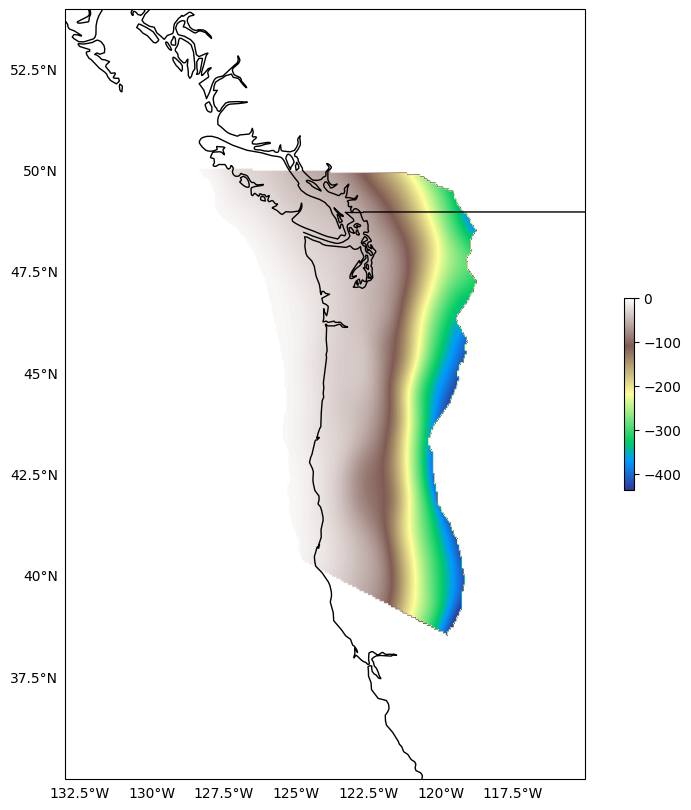

In [ ]:
plt.figure(figsize=(10,10))
ax=plot_elevation(x_slab,y_slab,z_slab, shade=False)

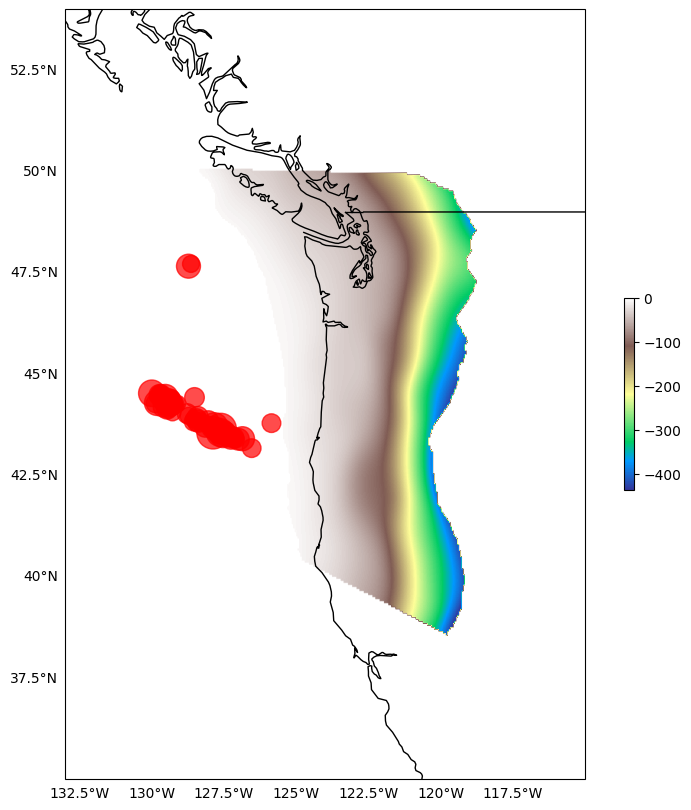

In [ ]:
plt.figure(figsize=(10,10))
ax=plot_elevation(x_slab,y_slab,z_slab, shade=False)

plt.scatter(events[ind].longitude,
            events[ind].latitude,
            events[ind].marker_size,
            color='r',alpha=0.7,
            transform=ccrs.PlateCarree())


In [ ]:
from scipy import interpolate
from scipy.interpolate import interp2d
from scipy.interpolate import interpn
from scipy.interpolate import RegularGridInterpolator

In [ ]:
interp = RegularGridInterpolator((y_slab,x_slab),z_slab,bounds_error=False, fill_value=0)

In [ ]:
slab_depth = -interp( (events['latitude'], events['longitude']))

In [ ]:
lons=(events.longitude).values
lons[lons<0] = lons[lons<0] + 360
lats=(events.latitude).values
from scipy.interpolate import RegularGridInterpolator
interp = RegularGridInterpolator( (slab.y.values,slab.x.values), slab.z.values,method="linear",bounds_error=False,fill_value=np.nan)
depth_interp=interp((lats,lons))

In [ ]:
ind = slab_depth > 0

eqdepth = events.depth[ind]
slabDepth = depth_interp[ind]

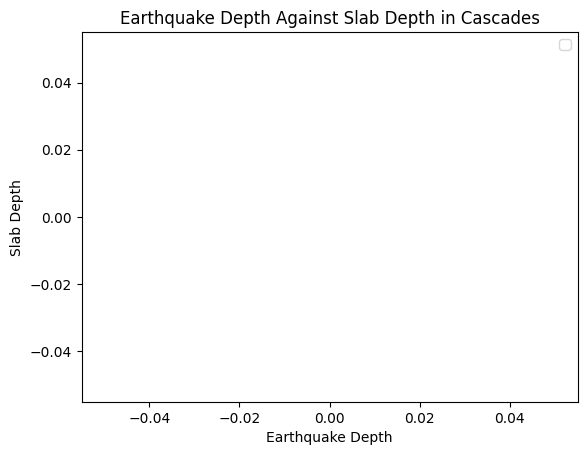

In [ ]:
plt.plot(eqdepth/1000, slabDepth,'.')

plt.title('Earthquake Depth Against Slab Depth in Cascades')
plt.xlabel('Earthquake Depth')
plt.ylabel('Slab Depth')
plt.legend()